<a href="https://colab.research.google.com/github/FatimaZohraBoumhaout/Occlusion/blob/main/GeneralLoadingOcclusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
! pip install scikit-image
! pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import random

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [41]:
dataset250 = pd.read_csv('/content/drive/MyDrive/ImageNet/val_imdb.txt', sep = '/', header = None, names = ["path", "label"])

n = random.randint(0, 250)
img_name_label = dataset250.iloc[n, 1]

print('Image name and label: {}'.format(img_name_label))
path, label_str = img_name_label.split()
label = int(label_str)
print('Image name: {}'.format(path))
print('Image label:{}'.format(label))

gdr_path = "/content/drive/MyDrive/ImageNet/val_250/val_250/"

img_path = gdr_path+path
print(img_path)


Image name and label: ILSVRC2012_val_00000226.JPEG 463
Image name: ILSVRC2012_val_00000226.JPEG
Image label:463
/content/drive/MyDrive/ImageNet/val_250/val_250/ILSVRC2012_val_00000226.JPEG


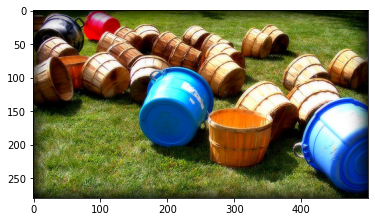

Image type: torch.FloatTensor
Image size: torch.Size([3, 280, 500])


In [42]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
%matplotlib inline

# function to convert PIL images to tensors.
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

# Read the image from file.
image = Image.open(img_path)
rgb_image = pil2tensor(image)

# Plot the image here using matplotlib.
def plot_image(tensor):
    plt.figure()
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()

plot_image(rgb_image)

# Show the image tensor type and tensor size here.
print('Image type: ' + str(rgb_image.type()))
print('Image size: ' + str(rgb_image.size()))


In [43]:
!git clone https://github.com/ruthcfong/pytorch_workflow

Cloning into 'pytorch_workflow'...
remote: Enumerating objects: 200, done.
remote: Total 200 (delta 0), reused 0 (delta 0), pack-reused 200
Receiving objects: 100% (200/200), 66.87 KiB | 964.00 KiB/s, done.
Resolving deltas: 100% (105/105), done.


In [44]:
!rm -rf pytorch_workflow

In [45]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
IMAGENET_MU = [0.485, 0.456, 0.406]
IMAGENET_SIGMA = [0.229, 0.224, 0.225]


class NormalizeInverse(transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super(NormalizeInverse, self).__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super(NormalizeInverse, self).__call__(tensor.clone())


class Clip(object):
    """Pytorch transformation that clips a tensor to be within [0,1]"""
    def __init__(self):
        return

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): tensor to be clipped.
        Returns:
            Tensor: clipped tensor.
        """
        t = tensor.clone()
        t[t > 1] = 1
        t[t < 0] = 0
        return t


def get_detransform(mu=IMAGENET_MU, sigma=IMAGENET_SIGMA):
    detransform = transforms.Compose([
        NormalizeInverse(mu, sigma),
        Clip(),
        # transforms.ToPILImage(),
    ])
    return detransform


In [47]:
convert_tensor = transforms.ToTensor()

size = (224, 224)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std) # (x - mean) / std
])

# x = convert_tensor(image)

x = transform(image)

In [52]:
def plot_image(tensor):
    plt.figure()
 
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


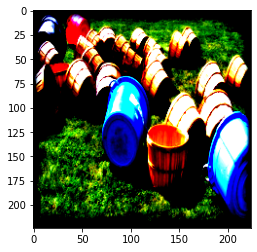

torch.Size([224, 224])


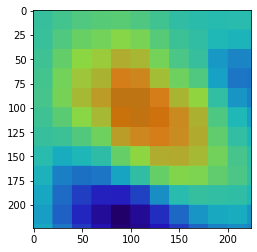

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def heat_map_gen(img_path, label, size, stride, model):
  image = Image.open(img_path)
  img = transform(image)
  plot_image(img)
  _, x, y = img.size()
  mask_sum = torch.zeros(3, x, y)
  sum = torch.zeros(3,x,y)
  # loop for each occlusion
  for i in range(0,x,stride):
    for j in range(0, y, stride):
      mask = torch.ones(1,x,y)
      mask[-1,i:i+size,j:j+size] = 0
      masked_img = img * mask
      # update masked image and mask
      with torch.no_grad():
        y_output = model(masked_img.unsqueeze(0))
      # print(y_output, y_output.shape)
      sum += y_output[0][label] * mask
      mask_sum += mask
  # plot heat map
  heat_map_tensor = 0.25*torch.divide(sum, mask_sum)
  heat_map_single = heat_map_tensor[0][:][:]

  print(heat_map_single.shape)
  # heat_map= heat_map_tensor.permute(1, 2, 0)

  plt.imshow(heat_map_single)
  plt.imshow(heat_map_single, cmap='jet', alpha=0.5) 
  

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.eval()
heat_map = heat_map_gen(img_path, label, 100, 20, model)